In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
N = 64
x = np.linspace(-10,10,N)
y = np.linspace(-10,10,N)

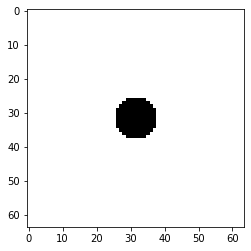

In [32]:
R = 2
xx, yy = np.meshgrid(x, y, sparse=True)
z = (np.sqrt(xx**2 + yy**2) >= R)*1
plt.imshow(z, "gray")


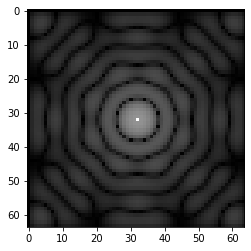

In [33]:
Fz = np.fft.fft2(z)
Fzcenter = np.fft.fftshift(Fz)
plt.imshow(np.log(1+np.abs(Fzcenter)), "gray")

In [3]:
from PIL import Image, ImageOps

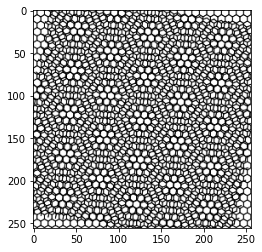

In [4]:
bilayer = np.array(ImageOps.grayscale(Image.open('lattice.png')))
plt.imshow(bilayer, "gray")

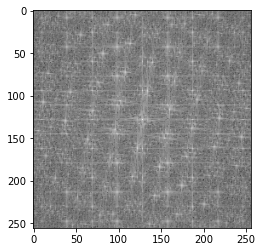

In [7]:
Fbilayer = np.fft.fft2(bilayer)
Fbilayercenter = np.fft.fftshift(Fbilayer)
plt.imshow(np.log(1+np.abs(Fbilayercenter)), "gray")

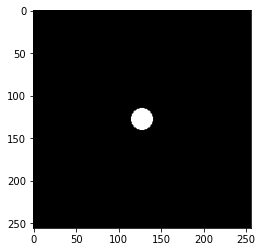

In [24]:
R = 1
xx, yy = np.meshgrid(x, y, sparse=True)
lowpass = (np.sqrt(xx**2 + yy**2) <= R)*1
plt.imshow(lowpass, "gray")

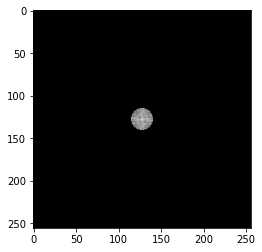

In [29]:
plt.imshow(np.log(1+np.abs(lowpass*Fbilayercenter)), "gray")

In [30]:
filtered = np.fft.ifft2(lowpass*Fbilayercenter)

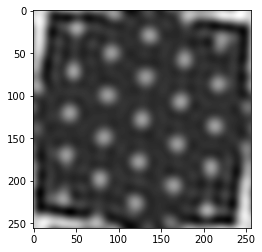

In [28]:
plt.imshow(np.log(1+np.abs(filtered)), "gray")